<DIV ALIGN=CENTER>

# Introduction to Regularization
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this notebook, we introduce the concept of regularization. 

-----

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=2.0)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-----
### Data

Before exploring different techniques for modeling a data set, we first
need data to analyze. To focus on the process of regularization, we will
stick to the simple _simulated_ data set we created in the [Introduction
to Linear Regression][ilr] notebook.

Note that since we randomly generate our data, every time this Notebook
is run, we will get different results. Take advantage of this feature to
compare the different approaches as the underlying data change.

-----
[ilr]: ../../Week1/notebooks/intro2lr.ipynb

In [2]:
# We define a simple function to fit.

np.random.seed(0)

def theModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1

    x = np.linspace(xmin, xmax, num)
    y = 0.25 + 0.5 * x - sigma * np.random.randn(len(x)) - sigma * x **2

    return(x, y)

----

### Polynomial Fitting

A simple first step is to see how different polynomial functions fit our
data. The scikit learn library allows us to compute a linear regression
by using a polynomial function. To simplify the process, we can use the
scikit learn library's pipeline feature to connect a polynomial fit to
the linear regression. Since we wish to compute different order
polynomial fits (to determine which one best approximates our data), we
place the pipeline creation, fitting, and scoring inside a loop.

-----

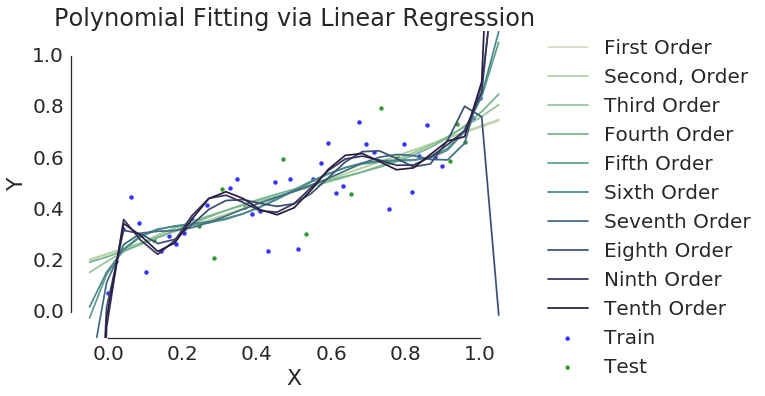

In [8]:
# Set the training fraction and maximum degree of polynomical fit
train_frac = 0.75
max_deg = 10
test_frac = 1.0 - train_frac

# Imports
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.cross_validation import train_test_split

# Make data
x, y = theModel(num = 50)

# Ready data set for cross-validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_frac)

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(max_deg, start=.5, rot=-.75)

lbls = ['First', 'Second,', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth']

xf = np.linspace(-0.05,1.05,25)

for idx, deg in enumerate(range(1, max_deg + 1)):
    est = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)

    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[deg - 1], label='{0} Order'.format(lbls[idx]))
    
ax.set(title='Polynomial Fitting via Linear Regression',
       xlabel='X', xlim=(-0.1, 1.1),
       ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

### Optimal Fitting

We can compute the MSE for each polynomial fit to determine which
polynomial best approximates our data. In this case, we see that, from
the **test** data, after a third or fourth order polynomial fit (in
general, the data is random and thus the results can vary) the accuracy
decreases.

In general, however, we don't (or can't) fit different polynomials and
compare the results. Thus, while this example is demonstrative of the
problem of overfitting and provides an explicit demonstration of the
optimal fitting function, we will want to explore more advanced
techniques.

----

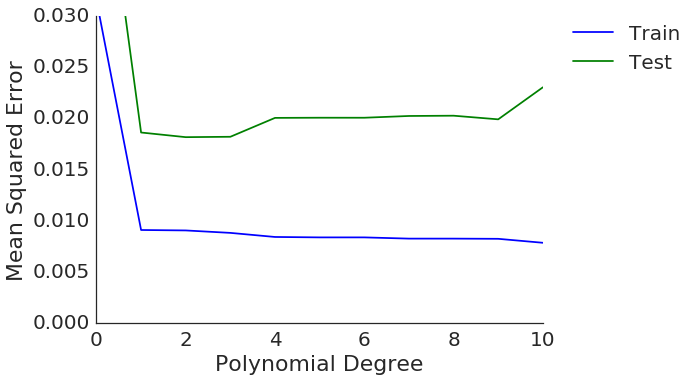

In [4]:
from sklearn.metrics import mean_squared_error as MSE

# Initialize arrays
train_error = np.empty(max_deg + 1)
test_error = np.empty(max_deg + 1)

for deg in range(max_deg + 1):
    est = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)
    train_error[deg] = MSE(y_train, est.predict(x_train[:, np.newaxis]))
    test_error[deg] = MSE(y_test, est.predict(x_test[:, np.newaxis]))

xp = np.arange(max_deg + 1)
plt.plot(xp, train_error, color='b', label='Train')
plt.plot(xp, test_error, color='g', label='Test')

plt.ylim((0.0, 0.03))

plt.ylabel('Mean Squared Error')
plt.xlabel('Polynomial Degree')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

### Ridge Regression


-----

Select Coefficients:

alpha           x      x**2      x**3      x**4      x**5      x**6      x**7      x**8      x**9
-------------------------------------------------------------------------------------------------
0.0e+00      2.22     -0.42   -132.87   1017.16  -3499.83   6509.97  -6753.71   3678.83   -820.79
1.0e-06      1.39     -1.90      1.20     -5.24      7.56      6.44     -6.19    -11.10      8.39
1.0e-04      1.44     -2.31      0.46      1.44      0.90     -0.21     -0.96     -0.79      0.55
1.0e-02      0.72     -0.38     -0.12      0.15      0.25      0.20      0.06     -0.10     -0.27
1.0e+00      0.21      0.13      0.07      0.04      0.02      0.01     -0.01     -0.01     -0.02


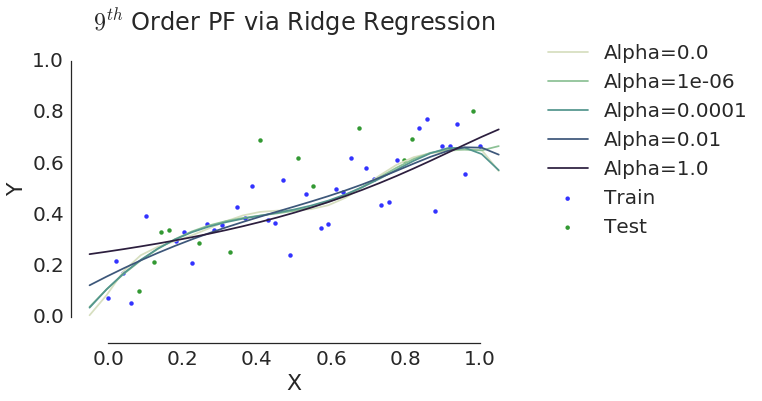

In [5]:
# Use Ridge Regression
from sklearn.linear_model import Ridge

#Show different alpha fits. Compare fit coeeficients.

alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(len(alpha), start=.5, rot=-.75)

print("Select Coefficients:\n")
print('alpha           x      x**2      x**3      x**4      x**5      x**6      x**7      x**8      x**9')
print('-------------------------------------------------------------------------------------------------')

for idx, al in enumerate(alpha):
    est = make_pipeline(PolynomialFeatures(9), Ridge(alpha=al))
    est.fit(x_train[:, np.newaxis], y_train)
    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[idx], label='Alpha={0}'.format(al))
    cfs = est.steps[-1][1].coef_.ravel()
    
    print('{0:4.1e}'.format(al), end='')
    for val in cfs[1:]:
        print('{0:10.2f}'.format(val), end='')
    
    print()

ax.set(title='$9^{th}$ Order PF via Ridge Regression',
    xlabel='X', xlim=(-0.1, 1.1),
    ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

### Lasso Regularization

-----

Select Coefficients:

alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9
----------------------------------------------------------------------
1.0e-06  1.272 -1.872  0.609  0.724  0.396  0.075 -0.114 -0.266 -0.309
1.0e-04  0.754 -0.469  0.000  0.101  0.342  0.000  0.000 -0.000 -0.216
1.0e-02  0.394  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
1.0e+00  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000


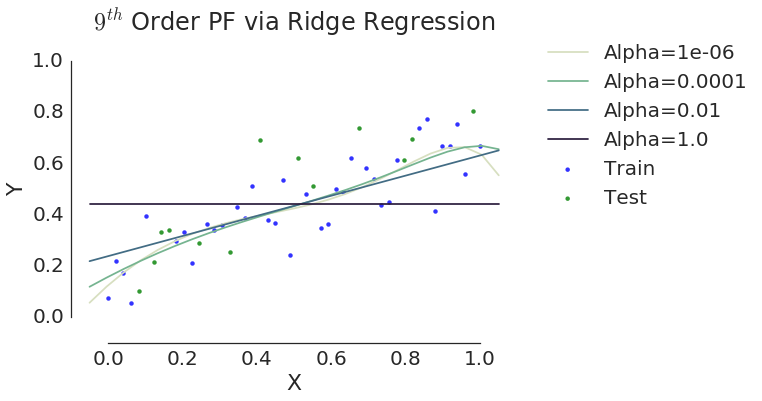

In [6]:
# Use Lasso
from sklearn.linear_model import Lasso

#Show different alpha fits. Compare fit coeeficients.

alpha = [1E-6, 1E-4, 1E-2, 1.0]

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(len(alpha), start=.5, rot=-.75)

print("Select Coefficients:\n")
print('alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9')
print('----------------------------------------------------------------------')

for idx, al in enumerate(alpha):
    est = make_pipeline(PolynomialFeatures(9), Lasso(alpha=al))
    est.fit(x_train[:, np.newaxis], y_train)
    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[idx], label='Alpha={0}'.format(al))
    cfs = est.steps[-1][1].coef_.ravel()

    print('{0:4.1e}'.format(al), end='')
    for val in cfs[1:]:
        print('{0:7.3f}'.format(val), end='')
    
    print()

ax.set(title='$9^{th}$ Order PF via Lasso Regression',
    xlabel='X', xlim=(-0.1, 1.1),
    ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)

-----

### Elastic Net

-----

Select Coefficients:

alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9
----------------------------------------------------------------------
1.0e-06  1.273 -1.874  0.610  0.724  0.399  0.079 -0.126 -0.263 -0.307
1.0e-04  0.867 -0.733 -0.000  0.311  0.395  0.002  0.000 -0.000 -0.332
1.0e-02  0.333  0.099  0.000  0.000  0.000  0.000  0.000  0.000  0.000
1.0e+00  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000


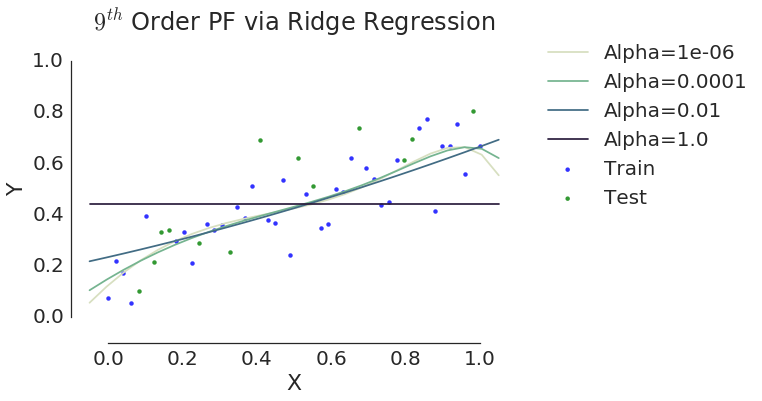

In [7]:
# Use Lasso
from sklearn.linear_model import ElasticNet

# Set L1/L2 ratio
l12_ratio = 0.5

#Show different alpha fits. Compare fit coeeficients.

alpha = [1E-6, 1E-4, 1E-2, 1.0]

# Start plot
ax = sns.regplot(x_train, y_train, fit_reg=False, color='b', label="Train")
ax = sns.regplot(x_test, y_test, fit_reg=False, color='g', label="Test")
cmp = sns.cubehelix_palette(len(alpha), start=.5, rot=-.75)

print("Select Coefficients:\n")
print('alpha        x   x**2   x**3   x**4   x**5   x**6   x**7   x**8   x**9')
print('----------------------------------------------------------------------')

for idx, al in enumerate(alpha):
    est = make_pipeline(PolynomialFeatures(9), ElasticNet(alpha=al, l1_ratio=l12_ratio))
    est.fit(x_train[:, np.newaxis], y_train)
    plt.plot(xf, est.predict(xf[:, np.newaxis]), c=cmp[idx], label='Alpha={0}'.format(al))
    cfs = est.steps[-1][1].coef_.ravel()

    print('{0:4.1e}'.format(al), end='')
    for val in cfs[1:]:
        print('{0:7.3f}'.format(val), end='')
    
    print()

ax.set(title='$9^{th}$ Order PF via Ridge Regression',
    xlabel='X', xlim=(-0.1, 1.1),
    ylabel='Y', ylim=(-0.1, 1.1))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #loc=4)
sns.despine(offset=0, trim=True)